**Development project for the implementation of the tree-child network reconstruction function in the field of phylogenetic networks.**

Author: Narcís Rosselló Payeras

Creation Date: 07/12/2021

Last Update: 07/12/2021

# **1. INITIALIZATION AND VARIABLES DECLARATION**

Paper:

https://link.springer.com/article/10.1007%2Fs00453-017-0320-6

Key Words:

https://evolution.berkeley.edu/evolibrary/article/0_0_0/evotrees_primer_07#:~:text=Outgroup%3A%20An%20outgroup%20is%20used,closely%20related%20to%20that%20clade.

**Outgroup:** An outgroup is used in phylogenetic analyses to figure out where the root of the tree should be placed (and sometimes which character state is ancestral on the tree). An outgroup is a lineage that falls outside the clade being studied but is closely related to that clade. All the members of the main clade (the ingroup) are more closely related to each other than they are to the outgroup (or outgroups, if more than one is used). The outgroups can usually be identified by locating the terminal taxa that branch off nearest the base of a phylogenetic tree. On this tree, the outgroup is the fairy shrimp � a group of crustaceans that are closely related to the insects. Note that some evolutionary trees don't include an outgroup.

**Ingroup:** An ingroup is the clade that is the focus of a phylogenetic analysis. In contrast, the outgroup is a taxon that is included in an analysis to figure out where the root of the tree should fall and sometimes which character state is ancestral for the ingroup (e.g., winglessness). On this tree, the ingroup includes all the insects.

References:
   - https://en.wikipedia.org/wiki/Q_Score
   - https://en.wikipedia.org/wiki/Outgroup_(cladistics)

In [ ]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import copy

# **2. FUNCTION DECLARATION**

This section declares all functions used in the main Q_Reconstruction function. The functions described in this section are separated into three groups, according to their level of abstraction.

1. In the first low-level group, the most basic functions that deal with data directly are declared.

2. In the second intermediate-level group, functions are declared that have clear and very concrete objectives but in a more developed way and that use functions from the first group.

3. In the third high-level group, functions that are closer to the final logic of the algorithm are declared. They are more abstractly developed and implement functions from the first two groups.

**Low-Level Functions**

The basic operating functions of the dictionary used are declared in this cell.

In [ ]:
"""
The GetDictValue function returns the value of the distance stored in the 
  dictionary between two leaves. All possible entries are returned, either in one
  leaf order or the reverse order.
Output: Integer
"""
def GetDictValue(dictionary, leaf1, leaf2):
  value = []
  try:
    value = dictionary[leaf1][leaf2]
  except:
    value = dictionary[leaf2][leaf1]
  return value


"""
The RemoveDictValue function removes the value of the distance in the dictionary
  between two leaves. All possible entries, whether in one leaf order or the 
  reverse, are removed.
Output: -
"""
def RemoveDictValue(dictionary, leaf):
  try:
    dictionary.pop(leaf)
  except:
    print("1: No Key with this value")
  for n in dictionary.keys():
    try:
      dictionary[n].pop(leaf)
    except:
      print("2: No Key with this value")


"""
The UpdateDictValue function updates the distance value in the dictionary between
  two leaves. All possible entries are updated, either in one leaf order or the
  reverse order.
Output: -
"""
def UpdateDictValue(dictionary, leaf1, leaf2, value):
  try:
    exists = dictionary[leaf1][leaf2]
    dictionary[leaf1].update({leaf2 : value})
  except:
    dictionary[leaf2].update({leaf1 : value})


"""
The CleanDict function eliminates all possible empty entries in the dictionary.
Output: Dictionary
"""
def CleanDict(dictionary):
  result = copy.deepcopy(dictionary)
  for n in dictionary.keys():
    if result[n] == {}:
      result.pop(n)
  return result

The basic functions dealing with the network are declared in this cell.

In [ ]:
"""
The GetLeaves function returns all leaves in the network.
Output: List of leaves
"""
def GetLeaves(network):
  leaves = []
  for node in network.nodes:
    if type(node) == str:
      leaves.append(node)
  return leaves


"""
The GetValue function returns the value of the name of the parent node of the 
  input node.
Output: Variable with parent name
"""
def GetValue(node):
  for n in node:
    return n



**Intermediate-Level Functions**

In [ ]:
"""
The Q_distance function implements the mathematical formula of the Q score. This
  formula is calculated based on the distance dictionary.
Output: Integer
"""
def Q_distance(s, t, r, D):
  q_distance = (1/2)*(D_max(r, s, D) + D_max(r, t, D) - D_min(s, t, D))
  return q_distance


"""
The D_max function returns the maximum distance between two leaves.
Output: Integer
"""
def D_max(x, y, D):
  return max(GetDictValue(D, x, y))


"""
The D_min function returns the minimum distance between two leaves.
Output: Integer
"""
def D_min(x, y, D):
  return min(GetDictValue(D, x, y))


"""
The FindCherryWeights function calculates the distances in the reconstruction 
  between u and v, between v and s, and between v and t. This function works for
  both positive c and negative c, when the path to s is greater than to t.
Output: Integer, Integer, Integer
"""
def FindCherryWeights(w_us, w_st, c):
  w_vs = w_us
  w_uv = 0
  incr = 0
  while incr <= w_us:
    w_vt = w_vs + c
    if w_vt + w_vs == w_st:
      return w_uv, w_vs, w_vt
    incr += 1
    w_vs = w_us - incr
    w_uv = incr


"""
The FindHWeights function calculates the weights for the edges between the u, v 
  and s nodes. This calculation is performed for the reconstruction of the network 
  with the element H.
Output: Integer
"""
def FindHWeights(w_u1s, w_st, w_u2t):
  w_v1s = w_st - w_u2t
  w_u1v1 = w_u1s - w_v1s
  return w_u1v1, w_v1s


"""
The GetSubset function returns true or false depending on whether or not d1 is a
  subset of d2, summing the value c.
Output: Boolean
"""
def GetSubset(d1, c, d2):
  for i in d1:
    subset = False
    for j in d2:
      if i + c == j:
        subset = True
    if not subset:
      return False
  return True


"""
The CutST function eliminates the central path of the case H for the specific 
  case of the leaves s and t. For this case the smallest distance between these two
  leaves is eliminated.
Output: List of new distances between s and t
"""
def CutST(s, t, D):
  result = []
  d_st = GetDictValue(D, s, t)
  for i in d_st:
    if i != min(d_st):
      result.append(i)
  return result


"""
The GetOutJoin function returns those distances between two leaves that do not
  pass through the central edge of H. For this, it is checked for all distances 
  plus c whether they lie within the other set of distances.
Output: List of distances
"""
def GetOutJoin(d1, d2, c):
  result = []
  for i in d1:
    add = True
    for j in d2:
      if j + c == i:
        add = False
    if add:
      result.append(i)
  return result

**High-Level Functions**

In [ ]:
"""
The Cut function obtains the distances between leaf s and leaf t that do not pass
  through the central edge of the form H between them. For this, the value of c is
  needed and from this the distances that do not pass through this central edge are
  obtained.
Output: List of distances
"""
def Cut(x, s, t, D, r):
  #C Calculation
  c = D_max(r, t, D) - D_max(r, s, D)
  distances = GetOutJoin(GetDictValue(D, t, x), GetDictValue(D, s, x), c)
  return distances


"""
The ReticulationTest function says, for case of the form H between two leaves, the
  leaf t passed by parameters has the parent as a reticular node.
Output: Boolean
"""
def ReticulationTest(D, X, s, t):
  c = D_max(r, t, D) - D_max(r, s, D)
  for x in X:
    if x not in [s, t]:
      if not GetSubset(GetDictValue(D, s, x), c, GetDictValue(D, t, x)):
        return False
  return True


"""
The UpdateD0 function updates the weights for the first case, Cherry shape between
  two leaves. For this case all distances to leaf t will disappear, as this leaf
  is removed from the list. The same happens in the list of available leaves.
Output: Dictionary with updated distances, List of leaves without t
"""
def UpdateD0(X, D, s, t):
  Dprima = copy.deepcopy(D)
  Xprima = copy.deepcopy(X)
  Xprima.remove(t)
  RemoveDictValue(Dprima, t)
  Dprima = CleanDict(Dprima)
  return Dprima, Xprima


"""
The UpdateD1 function updates the weights for the second case, form H between two
  sheets. For this case no leaf is removed. The distances that used the central 
  path will disappear. Moreover, only the distances to the leaf with the lattice
  parent of the H-shape, i.e. with t, are modified.
Output: Dictionary with updated distances
"""
def UpdateD1(X, D, s, t, r):
  Dprima = copy.deepcopy(D)
  for i in X:
    if i not in [s, t]:
      distances = Cut(i, s, t, D, r)
      UpdateDictValue(Dprima, i, t, distances)
  UpdateDictValue(Dprima, s, t, CutST(s, t, D))
  return Dprima


"""
The HReconstruction function reconstructs the H element of the network. It 
  modifies the network by adding the new element and assigns the relevant weights 
  to the affected edges. The modification occurs directly in the input network.
Output: -
"""
def HReconstruction(finalNetwork, s, t, D, r_depth):
  #Node Creation
  nodeV1 = 'v1{r_depth}'.format(r_depth = r_depth)
  nodeV2 = 'v2{r_depth}'.format(r_depth = r_depth)
  u1 = GetValue(finalNetwork[s])
  u2 = GetValue(finalNetwork[t])
  w_u2t = finalNetwork[u2][t]['weight']
  w_u1s = finalNetwork[u1][s]['weight']
  w_u1v1, w_v1s = FindHWeights(w_u1s, D_min(s, t, D), w_u2t)
  #Edge Division
  finalNetwork.remove_edge(u1, s)
  finalNetwork.remove_edge(u2, t)
  finalNetwork.add_edge(u1, nodeV1, weight = w_u1v1)
  finalNetwork.add_edge(u2, nodeV2, weight = 0) #0 Weight value
  finalNetwork.add_edge(nodeV1, s, weight = w_v1s)
  finalNetwork.add_edge(nodeV2, t, weight = w_u2t)
  finalNetwork.add_edge(nodeV1, nodeV2, weight = 0) #0 Weight value


"""
The CherryReconstruction reconstructs the cherry element of the network. It 
  modifies the network by adding the new element and assigns the relevant weights 
  to the affected edges. The modification occurs directly in the input network.
Output: -
"""
def CherryReconstruction(finalNetwork, s, t, D, r, r_depth):
  u = GetValue(finalNetwork[s])
  w_us = finalNetwork[s][u]["weight"]
  c = D_max(r, t, D) - D_max(r, s, D)
  w_uv, w_vs, w_vt = FindCherryWeights(w_us, D_min(s, t, D), c)
  nodeV = 'v{r_depth}'.format(r_depth = r_depth)
  finalNetwork.remove_edge(u, s)
  finalNetwork.add_edge(u, nodeV, weight = w_uv)
  finalNetwork.add_edge(nodeV, s, weight = w_vs)
  finalNetwork.add_edge(nodeV, t, weight = w_vt)


"""
The CreateDoubleVertexNet function creates a defined and concrete type of structure.
  All the weight found in D, there being only one, is assigned to the edge between
  the root and the leaf in X, while the weight between the root and r will be 0.
Output: -
"""
def CreateDoubleVertexNet(finalNetwork, X, D, r):
  for leaf in X:
    if leaf == r:
      finalNetwork.add_edge(leaf, 0, weight = 0)
    else:
      finalNetwork.add_edge(leaf, 0, weight = GetDictValue(D, leaf, r)[0])


"""
The Find2ElementSubset function returns a pair of leaves s and t, which have the
  maximum value of the formula Q score. In case there is more than one pair of 
  leaves with the same maximum, the first one is chosen.
Output: List of 2 leaves, Integer (Max value of q_score)
"""
def Find2ElementSubset(X, D, r):
  q_max = 0
  q_pair = []
  XWithoutR = [x for x in X if x != "r"]
  for x in XWithoutR:
    for y in XWithoutR:
      if x != y:
        q_distance = Q_distance(x, y, r, D)
        if q_distance > q_max:
          q_max = q_distance
          q_pair = [x, y]
  return q_pair, q_max

# **3. MAIN ALGORITHM**

In [ ]:
#X: Leaf set
#D: Distance matrix
#r: out-group
def Q_Algorithm(X, D, r, recursivity_depth = 0):
  finalNetwork = nx.Graph()
  print()
  print("Recursivity Depth: ", recursivity_depth)
  #0
  if len(X) == 0:
    print("Case 0: Invalid Input")
    return finalNetwork

  #1
  elif len(X) == 1:
    if r == X[0]:
      print("Case 1: Unique element")
      return finalNetwork.add_node(r)
    return finalNetwork

  #2
  elif len(X) == 2:
    CreateDoubleVertexNet(finalNetwork, X, D, r)
    print("Case 2: Double Vertex network created")
    return finalNetwork

  #3
  else:
    #Find max distance subset - {r}
    subset, max_distance = Find2ElementSubset(X, D, r)
    
    #Case 0-reticulated cherry
    if len(GetDictValue(D, subset[0], subset[1])) == 1:
      print("Cherry Found")
      print("For pair of leaves {subset}, it returns max q_score = {max}".format(subset = subset, max = max_distance))
      #i. Reduce
      Dprima, Xprima = UpdateD0(X, D, subset[0], subset[1])
      print("Distances Dictionary: ")
      print(Dprima)
      #ii. Q-Algorithm(X', D', r)
      finalNetwork = Q_Algorithm(Xprima, Dprima, r, recursivity_depth+1)

      if recursivity_depth >= 0:
        CherryReconstruction(finalNetwork, subset[0], subset[1], D, r, recursivity_depth)

      
      print()
      print("Cherry Reconstructed in depth ", recursivity_depth)
    #Case 1-reticulated cherry
    else:
      if ReticulationTest(D, X, subset[0], subset[1]):
        s = subset[0]
        t = subset[1]
      #Cambiar elif por else
      elif ReticulationTest(D, X, subset[1], subset[0]):
        s = subset[1]
        t = subset[0]
      print("H Found")
      print("For pair of leaves {subset}, it returns max q_score = {max}".format(subset = [s,t], max = max_distance))
      #i. Cut
      Dprima = UpdateD1(X, D, s, t, r)
      print("Distances Dictionary: ")
      print(Dprima)
      #ii. Q-Algorithm(X, D', r)
      finalNetwork = Q_Algorithm(X, Dprima, r, recursivity_depth+1)

      if recursivity_depth >= 0:
        HReconstruction(finalNetwork, s, t, D, recursivity_depth)

      
      print()
      print("H Reconstructed in depth ", recursivity_depth)
  return finalNetwork

# **4. DISTANCE MATRIX EXTRACTION FROM ORIGINAL NETWORK**

In [ ]:
"""
The GetDistance function is a recursive function that returns the distance between
  two nodes. This distance is constrained by a number of factors such as that it
  cannot repeat path and the path has to be up-down. The distance obtained is
  obtained from the recursion, returning all possible available paths that meet
  the requirements.
Output: List of weights, Boolean if found at least one path
"""
def GetDistance(graph, node1, node2, visitedNodes = [], direction = 'Up'):
  finalWeight = []
  visitedNodesAux = copy.deepcopy(visitedNodes)
  foundFinal = False
  for node in graph[node1]:
    if node not in visitedNodes:
      #Checking Direction    
      #Up-Down Path, when goes down it can't go up again
      if (direction == 'Down' and GetDirection(node1, node) == 'Down') or direction == 'Up':
        visitedNodesAux.append(node1)
        if node == node2:
          return input[node1][node]["weight"], True
        weight, found = GetDistance(graph, node, node2, visitedNodesAux, GetDirection(node1, node))
        if found:
          if type(weight) == list:
            for i in weight:
              finalWeight.append(i + input[node1][node]["weight"])
          else:
            finalWeight.append(weight + input[node1][node]["weight"])
          foundFinal = found
    
  return finalWeight, foundFinal


"""
The GetDirection function returns the type of path to follow to the next node,
  either Down or Up.
Output: String ('Down', 'Up')
"""
def GetDirection(origin, destination):
  try:
    if origin < destination:
      return 'Down'
    else:
      return 'Up'
  #It means it goes to a leaf
  except:
    if type(origin) == int:
      return 'Down'
    else:
      return 'Up'


"""
The GetDistancesMatrix function constructs for all leaves the distance dictionary.
  Between two leaves there can be one or more possible distances, depending on
  whether there are different possible paths to follow following the defined 
  constraints.
Output: Dictionary with distances, List of leaves
"""
def GetDistancesMatrix(graph):
  leaves = GetLeaves(graph)
  distanceMatrix = {}
  for n1, leaf1 in enumerate(leaves):
    distanceMatrixLeaf = {}
    for n2 in range(n1+1, len(leaves)):
      out1, out2 = GetDistance(graph, leaf1, leaves[n2])
      if out2:
        distanceMatrixLeaf.update({leaves[n2] : out1})
    if len(distanceMatrixLeaf) > 0:
      distanceMatrix.update({leaf1 : distanceMatrixLeaf})
  
  return distanceMatrix, leaves

# **5. EXAMPLE**

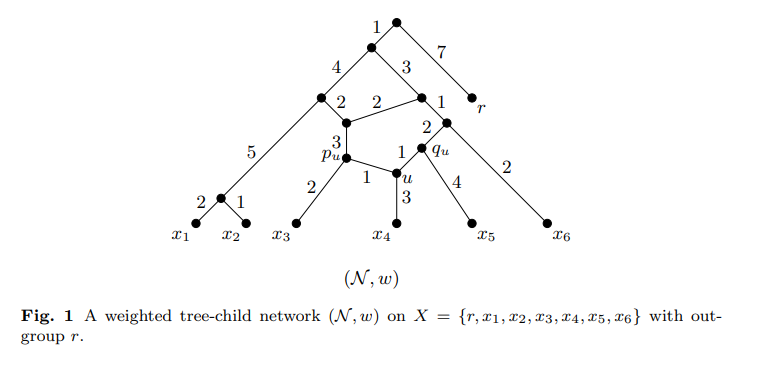

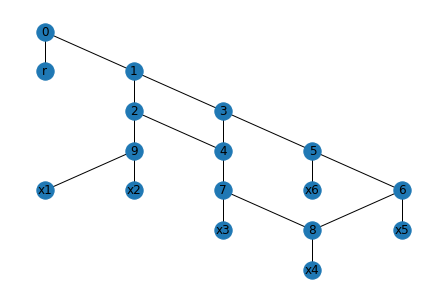

In [ ]:
input = nx.Graph()
input.add_edge(0, 'r', weight = 7)
input.add_edge(0, 1, weight = 1)
input.add_edge(1, 2, weight = 4)
input.add_edge(1, 3, weight = 3)
input.add_edge(2, 4, weight = 2)
input.add_edge(2, 9, weight = 5)
input.add_edge(3, 4, weight = 2)
input.add_edge(3, 5, weight = 1)
input.add_edge(4, 7, weight = 3)
input.add_edge(5, 6, weight = 2)
input.add_edge(5, 'x6', weight = 2)
input.add_edge(6, 'x5', weight = 4)
input.add_edge(6, 8, weight = 1)
input.add_edge(7, 8, weight = 1)
input.add_edge(7, 'x3', weight = 2)
input.add_edge(8, 'x4', weight = 3)
input.add_edge(9, 'x1', weight = 2)
input.add_edge(9, 'x2', weight = 1)

pos = graphviz_layout(input, prog="dot")
nx.draw(input, pos, with_labels = True)
plt.show()

In [ ]:
D, X = GetDistancesMatrix(input)
r = 'r'
print('Distance Dictionary/Matrix')
D

Distance Dictionary/Matrix


{'r': {'x1': [19],
  'x2': [18],
  'x3': [19, 18],
  'x4': [21, 20, 18],
  'x5': [18],
  'x6': [14]},
 'x1': {'x2': [3]},
 'x3': {'x1': [14, 21], 'x2': [13, 20], 'x4': [21, 14, 6]},
 'x4': {'x1': [21, 16, 23], 'x2': [20, 15, 22]},
 'x5': {'x1': [21], 'x2': [20], 'x3': [21, 14], 'x4': [23, 16, 8]},
 'x6': {'x1': [17], 'x2': [16], 'x3': [17, 10], 'x4': [19, 12, 8], 'x5': [8]}}

In [ ]:
print("List of leaves")
X

List of leaves


['r', 'x6', 'x5', 'x3', 'x4', 'x1', 'x2']

In [ ]:
finalNetwork = Q_Algorithm(X, D, r)


Recursivity Depth:  0
H Found
For pair of leaves ['x3', 'x4'], it returns max q_score = 17.0
Distances Dictionary: 
{'r': {'x6': [14], 'x5': [18], 'x3': [19, 18], 'x4': [18], 'x1': [19], 'x2': [18]}, 'x6': {'x5': [8], 'x3': [17, 10], 'x4': [8], 'x1': [17], 'x2': [16]}, 'x5': {'x3': [21, 14], 'x4': [8], 'x1': [21], 'x2': [20]}, 'x3': {'x4': [21, 14], 'x1': [14, 21], 'x2': [13, 20]}, 'x4': {'x1': [21], 'x2': [20]}, 'x1': {'x2': [3]}}

Recursivity Depth:  1
Cherry Found
For pair of leaves ['x1', 'x2'], it returns max q_score = 17.0
1: No Key with this value
Distances Dictionary: 
{'r': {'x6': [14], 'x5': [18], 'x3': [19, 18], 'x4': [18], 'x1': [19]}, 'x6': {'x5': [8], 'x3': [17, 10], 'x4': [8], 'x1': [17]}, 'x5': {'x3': [21, 14], 'x4': [8], 'x1': [21]}, 'x3': {'x4': [21, 14], 'x1': [14, 21]}, 'x4': {'x1': [21]}}

Recursivity Depth:  2
Cherry Found
For pair of leaves ['x5', 'x4'], it returns max q_score = 14.0
Distances Dictionary: 
{'r': {'x6': [14], 'x5': [18], 'x3': [19, 18], 'x1': [19

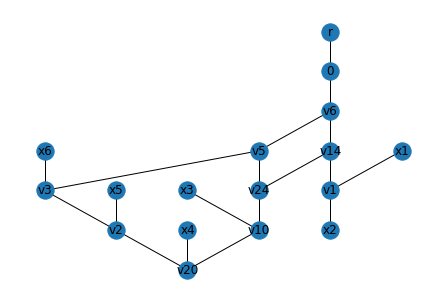

In [ ]:
pos = graphviz_layout(finalNetwork, prog="dot")
nx.draw(finalNetwork, pos, with_labels = True)
plt.show()

In [ ]:
nx.info(finalNetwork)

'Graph with 17 nodes and 18 edges'

In [ ]:
nx.info(input)

'Graph with 17 nodes and 18 edges'

In [ ]:
finalNetwork.size(weight="weight")

43.0

In [ ]:
input.size(weight="weight")

46.0

As a final consideration of the reconstruction of the network, although we do not obtain exactly the same networks with the same weights, we can see how, by changing the names with the original ones, we obtain the same distance matrix in the two networks. In this way, it can be seen how they have the same number of nodes, the same number of edges, different weights and total sum of these but equivalent in the formation of the distance matrix.

In [ ]:
#Equivalences
mapping = {
    'v6': 1,
    'v14': 2,
    'v5': 3,
    'v24': 4,
    'v1': 9,
    'v10': 7,
    'v20': 8,
    'v2': 6,
    'v3': 5
}
finalNetwork = nx.relabel_nodes(finalNetwork, mapping)

#Equivalent paths. Same distance matrix is reproduced.
DReconstructed, XReconstructed = GetDistancesMatrix(finalNetwork)
DReconstructed

{'r': {'x1': [19],
  'x2': [18],
  'x3': [18, 19],
  'x4': [20, 18, 21],
  'x5': [18],
  'x6': [14]},
 'x1': {'x2': [3], 'x3': [21, 14], 'x4': [23, 21, 16], 'x5': [21]},
 'x3': {'x2': [20, 13], 'x4': [14, 21, 6], 'x5': [14, 21]},
 'x4': {'x2': [20, 22, 15]},
 'x5': {'x2': [20], 'x4': [23, 16, 8]},
 'x6': {'x1': [17], 'x2': [16], 'x3': [17, 10], 'x4': [19, 12, 8], 'x5': [8]}}